간(GAN)을 시작하기에 앞서 케라스에서 네트워크와 모델 개념 정립을 먼저 한 후에 간단한 간모델을 만들어보겠습니다. 네트워크와 모델 개념을 레고 사람에 비유를 들어보겠습니다. 초반부는 귀엽겠지만 후반부에는 조금 무서울 수 있으니 노약자나 임산부는 주의해서 보시기 바랍니다.

---

### 간(GAN)보기에 앞서

간관련 공부를 하다보면 네트워크도 여러개 나오고 모델과 손실함수도 여러개라서 상당히 헷갈렸습니다. 기초적인 딥러닝이나 케라스 개념을 익히셨다면 간보기에 앞서 네트워크와 모델 개념을 분리하고, 모델에서도 손실함수와 최적화기도 분리해서 개념을 정립하면 기본 간 모델은 물론 복잡한 간 모델을 이해하는 데 도움이 많이 될 것 같습니다. 

---

### 네트워크

신경망에서 가장 기본적인 요소가 '뉴론'입니다. 이러한 뉴론 여러개가 구성된 것이 '레이어'이고 레이어가 여러 층으로 쌓여있는 것을 '네트워크'라 합니다. 입력 뉴런과 출력 뉴런 간에 연결선을 시냅스라 부르고 이 연결 강도를 '가중치'라고 합니다. 아래 그림은 입력 4개에 출력 3개 뉴런을 가진 전결합층을 표한한 것입니다. (a)에서 보면 학습해야할 녹색 가중치 블록이 12개가 있습니다. 이를 좀 더 간단하게 표시한 것이 (b)인데, 여기서는 가중치가 연결선으로만 표시되어 있습니다. (c)는 (b)를 좀 더 간략하게 표시한 것입니다. (c)의 아래 그림을 보면 '3'으로 표기되어 있는 데, 이는 출력 뉴런의 수를 표기한 것입니다. 케라스에서는 입력 뉴런 수는 입력에 따라 정해지기 때문에 입력층이 아닌 은닉층에서는 따로 지정할 필요는 없습니다.

![img](http://tykimos.github.io/warehouse/2018-1-2-One_Slide_GAN_Network_and_Model_1.png)

여러개의 층을 쌓아보자

![img](http://tykimos.github.io/warehouse/2018-1-2-One_Slide_GAN_Network_and_Model_2.png)

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.advanced_activations import LeakyReLU

generator = Sequential()
generator.add(Dense(256, input_dim=100))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

입출력에 대한 설명.

![img](http://tykimos.github.io/warehouse/2018-1-2-One_Slide_GAN_Network_and_Model_3.png)

(-0.5, 27.5, 27.5, -0.5)

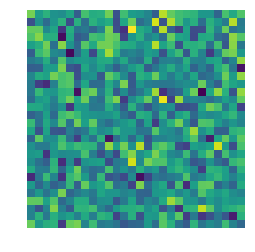

In [12]:
import numpy as np

random_latent_vectors = np.random.normal(0, 1, size=[1, 100])

generated_data = generator.predict(random_latent_vectors)
generated_images = generated_data.reshape(1, 28, 28)

%matplotlib inline
import matplotlib.pyplot as plt
        
plt.imshow(generated_images[0], interpolation='nearest')
plt.axis('off')

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# 1. 데이터셋 생성하기

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# 2. 모델 구성하기

# 2.1 생성기 모델
generator = Sequential()
generator.add(Dense(256, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

# 2.2 판별기 모델
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

# 2.3 간 모델
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

# 3. 모델 학습과정 설정하기

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# 3.1 판별기 모델 학습과정 설정
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# 3.2 간 모델 학습과정 설정
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=adam)



dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./warehouse/simplegan/images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./warehouse/simplegan/images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./warehouse/simplegan/models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./warehouse/simplegan/models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        plotGeneratedImages(e)        
        
        if e == 1 or e % 20 == 0:

            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(200, 128)

---

### 사소한 변화를 무시해주는 맥스풀링(Max Pooling) 레이어

컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만듭니다. 이것은 지역적인 사소한 변화가 영향을 미치지 않도록 합니다. 

    MaxPooling2D(pool_size=(2, 2))

주요 인자는 다음과 같습니다.
* pool_size : 수직, 수평 축소 비율을 지정합니다. (2, 2)이면 출력 영상 크기는 입력 영상 크기의 반으로 줄어듭니다.

예를 들어, 입력 영상 크기가 4 x 4이고, 풀 크기를 (2, 2)로 했을 때를 도식화하면 다음과 같습니다. 녹색 블록은 입력 영상을 나타내고, 노란색 블록은 풀 크기에 따라 나눈 경계를 표시합니다. 해당 풀에서 가장 큰 값을 선택하여 파란 블록으로 만들면, 그것이 출력 영상이 됩니다. 가장 오른쪽은 맥스풀링 레이어를 약식으로 표시한 것입니다.

![lego_12](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_12.png)

이 레이어는 영상의 작은 변화라던지 사소한 움직임이 특징을 추출할 때 크게 영향을 미치지 않도록 합니다. 영상 내에 특징이 세 개가 있다고 가정했을 때, 아래 그림에서 첫 번째 영상을 기준으로 두 번째 영상은 오른쪽으로 이동하였고, 세 번째 영상은 약간 비틀어 졌고, 네 번째 영상은 조금 확대되었지만, 맥스풀링한 결과는 모두 동일합니다. 얼굴 인식 문제를 예를 들면, 맥스풀링의 역할은 사람마다 눈, 코, 입 위치가 조금씩 다른데 이러한 차이가 사람이라고 인식하는 데 있어서는 큰 영향을 미치지 않게 합니다.

![lego_13](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_13.png)

---

### 영상을 일차원으로 바꿔주는 플래튼(Flatten) 레이어

CNN에서 컨볼루션 레이어나 맥스풀링 레이어를 반복적으로 거치면 주요 특징만 추출되고, 추출된 주요 특징은 전결합층에 전달되어 학습됩니다. 컨볼루션 레이어나 맥스풀링 레이어는 주로 2차원 자료를 다루지만 전결합층에 전달하기 위해선 1차원 자료로 바꿔줘야 합니다. 이 때 사용되는 것이 플래튼 레이어입니다. 사용 예시는 다음과 같습니다.

    Flatten()
    
이전 레이어의 출력 정보를 이용하여 입력 정보를 자동으로 설정되며, 출력 형태는 입력 형태에 따라 자동으로 계산되기 때문에 별도로 사용자가 파라미터를 지정해주지 않아도 됩니다. 크기가 3 x 3인 영상을 1차원으로 변경했을 때는 도식화하면 다음과 같습니다.

![lego_14](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_14.png)

---

### 한 번 쌓아보기

지금까지 알아본 레이어를 이용해서 간단한 컨볼루션 신경망 모델을 만들어보겠습니다. 먼저 간단한 문제를 정의해봅시다. 손으로 삼각형, 사각형, 원을 손으로 그린 이미지가 있고 이미지 크기가 8 x 8이라고 가정해봅니다. 삼각형, 사각형, 원을 구분하는 3개의 클래스를 분류하는 문제이기 때문에 출력 벡터는 3개여야 합니다. 필요하다고 생각하는 레이어를 구성해봤습니다.

![lego_22](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_22.png)

* 컨볼루션 레이어 : 입력 이미지 크기 8 x 8, 입력 이미지 채널 1개, 필터 크기 3 x 3, 필터 수 2개, 경계 타입 'same', 활성화 함수 'relu'

![lego_15](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_15.png)

* 맥스풀링 레이어 : 풀 크기 2 x 2

![lego_16](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_16.png)

* 컨볼루션 레이어 : 입력 이미지 크기 4 x 4, 입력 이미지 채널 2개, 필터 크기 2 x 2, 필터 수 3개, 경계 타입 'same', 활성화 함수 'relu'

![lego_17](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_17.png)

* 맥스풀링 레이어 : 풀 크기 2 x 2

![lego_18](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_18.png)

* 플래튼 레이어

![lego_19](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_19.png)

* 댄스 레이어 : 입력 뉴런 수 12개, 출력 뉴런 수 8개, 활성화 함수 'relu'

![lego_20](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_20.png)

* 댄스 레이어 : 입력 뉴런 수 8개, 출력 뉴런 수 3개, 활성화 함수 'softmax'

![lego_21](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_21.png)

모든 레이어 블록이 준비되었으니 이를 조합해 봅니다. 입출력 크기만 맞으면 블록 끼우듯이 합치면 됩니다. 참고로 케라스 코드에서는 가장 첫번째 레이어를 제외하고는 입력 형태를 자동으로 계산하므로 이 부분은 신경쓰지 않아도 됩니다. 레이어를 조립하니 간단한 컨볼루션 모델이 생성되었습니다. 이 모델에 이미지를 입력하면, 삼각형, 사각형, 원을 나타내는 벡터가 출력됩니다.

![lego_23](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_lego_23.png)

그럼 케라스 코드로 어떻게 구현하는 지 알아봅니다. 먼저 필요한 패키지를 추가하는 과정입니다. 케라스의 레이어는 'keras.layers'에 정의되어 있으며, 여기서 필요한 레이어를 추가합니다. 

In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

Using Theano backend.


Sequential 모델을 하나 생성한 뒤 위에서 정의한 레이어를 차례차레 추가하면 컨볼루션 모델이 생성됩니다.

In [2]:
model = Sequential()

model.add(Conv2D(2, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(3, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

생성한 모델을 케라스에서 제공하는 함수를 이용하여 가시화 시켜봅니다.

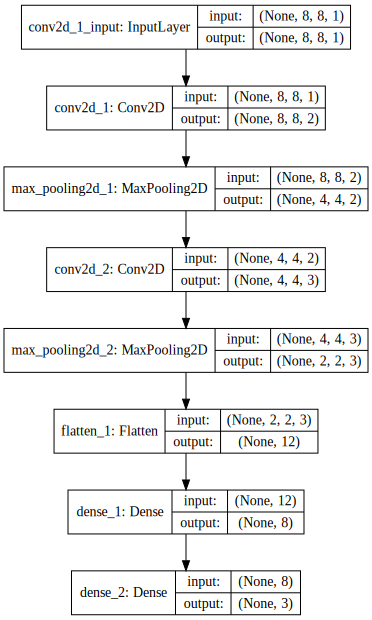

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![model](http://tykimos.github.io/warehouse/2017-1-27_CNN_Layer_Talk_model.svg)

---

### 요약

컨볼루션 신경망 모델에서 사용되는 주요 레이어의 원리와 역할에 대해서 알아보았고 레이어를 조합하여 간단한 컨볼루션 신경망 모델을 만들어봤습니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/lecture/)
* 이전 : [딥러닝 이야기/다층 퍼셉트론 모델 만들어보기](https://tykimos.github.io/2017/02/04/MLP_Getting_Started/)
* 다음 : [딥러닝 이야기/컨볼루션 신경망 모델 만들어보기](https://tykimos.github.io/2017/03/08/CNN_Getting_Started/)